# Importation des librairies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random

# Paramètres

In [2]:
IMAGES_DIR_NAME = "images"
MASKS_DIR_NAME = "masks"

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

TEST_SET_PROPORTION = 0.1

# Préparation des données
## Importation et prétraitement

In [15]:
images = []
masks = []

# Chemins des fichiers images et masques
image_paths = list(Path(IMAGES_DIR_NAME).iterdir())
mask_paths = list(Path(MASKS_DIR_NAME).iterdir())

# Ignorer .DS_Store
image_paths = [p for p in image_paths if p.name != '.DS_Store']
mask_paths = [p for p in mask_paths if p.name != '.DS_Store']

# Trier les chemins pour avoir le même indice
image_paths.sort()
mask_paths.sort()

# Parcourir et ouvrir les images et les masques
for image_path, mask_path in zip(image_paths, mask_paths):
    if image_path.name.endswith(".png") and mask_path.name.endswith(".png"):
        image = np.array(
            Image.open(image_path).convert("RGB").resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        )
        image = image / 255

        mask = np.array(
            Image.open(mask_path).convert("L").resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        )
        mask[mask != 0] = 1

        images.append(image)
        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

## Afficher une image et son masque

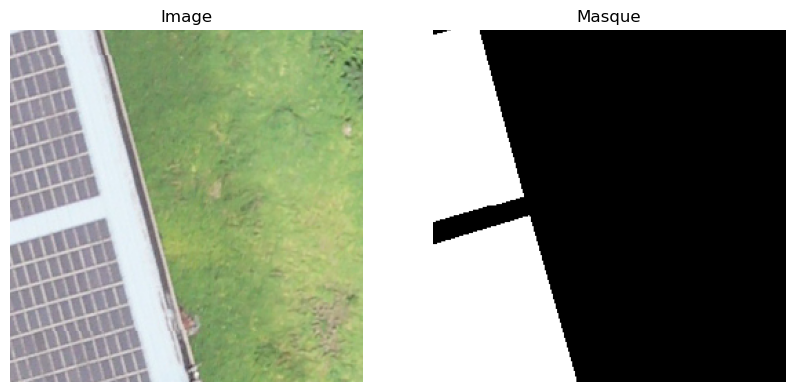

In [18]:
random_index = random.randint(0, len(images)-1)

random_image = images[random_index]
random_mask = masks[random_index]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(random_image)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(random_mask, cmap='gray')
axes[1].set_title('Masque')
axes[1].axis('off')

plt.show()

## Classer données en groupe d'entrainement et de test

In [19]:
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size = TEST_SET_PROPORTION, random_state=42)


In [20]:
images_train = torch.tensor(images_train).float()
images_test = torch.tensor(images_test).float()
masks_train = torch.tensor(masks_train).float()
masks_test = torch.tensor(masks_test).float()

# Transposer les dimensions des données pour correspondre aux attentes du modèle
images_train = images_train.permute(0, 3, 1, 2)
images_test = images_test.permute(0, 3, 1, 2)
masks_train = masks_train.unsqueeze(1)  # Ajouter une dimension pour les masques
masks_test = masks_test.unsqueeze(1)  

train_set = TensorDataset(images_train, masks_train)
test_set = TensorDataset(images_test, masks_test)

# Modèle FCN

In [21]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True), # Upsample à la taille d'entrée
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Créer une instance du modèle
model = FCN()

# Entrainer modèle

In [26]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Définir les ensembles de données et les chargeurs de données
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Entraîner le modèle
for epoch in range(10):  # 10 epochs
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

        # Calculer la perte moyenne sur l'ensemble de test
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}, Test Loss: {test_loss}")

Epoch 1, Test Loss: 0.45116867423057555
Epoch 2, Test Loss: 0.3248878538608551
Epoch 3, Test Loss: 0.2570481806993484
Epoch 4, Test Loss: 0.22108223736286164
Epoch 5, Test Loss: 0.23081318736076356
Epoch 6, Test Loss: 0.2316231608390808
Epoch 7, Test Loss: 0.17967281937599183
Epoch 8, Test Loss: 0.1820990636944771
Epoch 9, Test Loss: 0.17430920153856277
Epoch 10, Test Loss: 0.17752853780984879


## Enregistrer modèle

In [29]:
torch.save(model.state_dict(), "nope.pt")

# Test manuel du modèle

In [23]:
# Charger le modèle entraîné
model = FCN()
model.load_state_dict(torch.load("first_fcn.pt"))
model.eval()

FCN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Upsample(scale_factor=4.0, mode='bilinear')
    (4): Sigmoid()
  )
)

/var/folders/58/kss5xcz96wngl0k4m5x5jrr00000gn/T/ipykernel_60745/1215133878.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image = torch.tensor(random_image).permute(0, 1, 2).unsqueeze(0).float()


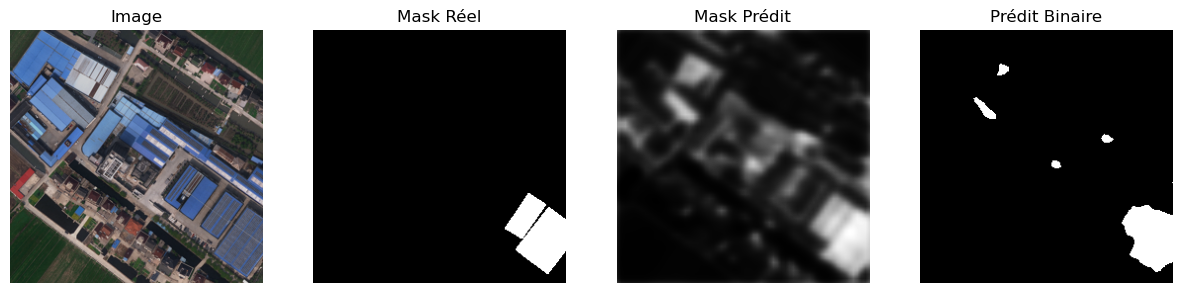

In [25]:
# Charge image au hasard
random_index = random.randint(0, len(images_test) - 1)
random_image = images_test[random_index]
random_mask = masks_test[random_index]

input_image = torch.tensor(random_image).permute(0, 1, 2).unsqueeze(0).float()

# Passer image dans le modèle
with torch.no_grad():
    model.eval()
    output = model(input_image)
    binary_output = (output > 0.5).float()

# Afficher image
predicted_mask = output.squeeze().cpu().numpy()
binary_predicted = binary_output.squeeze().cpu().numpy()
input_image_tab = input_image.squeeze().permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(input_image_tab)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(random_mask.squeeze(), cmap='gray')
axes[1].set_title('Mask Réel')
axes[1].axis('off')

axes[2].imshow(predicted_mask, cmap='gray')
axes[2].set_title('Mask Prédit')
axes[2].axis('off')

axes[3].imshow(binary_predicted, cmap='gray')
axes[3].set_title('Prédit Binaire')
axes[3].axis('off')


plt.show()